<img src="logo_UNSAM.jpg" align="right" width="120">


# <center>Trabajo final: Análisis y procesamiento de señales: *Detección de crisis epilépticas mediante análisis de EEG*</center> 

### <center> - Alumna: Lola Pampin</center> 

### <center> - Profesor: Mariano Llamedo Soria</center> 

### <center>Febrero 2026</center> 

## <center> Universidad Nacional de San Martín, Escuela de Ciencia y Tecnología</center> 




# **I. Introducción**
## *Marco clinico*
### Electrocargiograma
El electrocardiograma (ECG) es un estudio que mide las señales eléctricas del corazón durante cada latido. Su análisis permite identificar patologías, alteraciones del ritmo cardíaco y variaciones en la conducción eléctrica. Los principales componentes de un latido son:
- *Onda P*: representa la despolarización auricular (las cavidades superiores del corazón se activan eléctricamente). Es de baja amplitud (0.1-0.2 mV) y relativamente lenta.
- *Complejo QRS*: corresponde a la despolarización ventricular (activación eléctrica de los ventrículos, las cavidades encargadas de bombear sangre al cuerpo). Es el componente de mayor energía y rapidez en el ECG. Su pendiente pronunciada requiere preservar componentes de frecuencia relativamente altas.
- *Onda T*: asociada a la repolarización ventricular (luego de activarse, las células vuelven a su voltaje "de reposo"). Es más ancha que la onda P y su contenido espectral es de menor frecuencia que el QRS.
### **Epilepsia** 
La epilepsia es un trastorno neurológico crónico caracterizado por la aparición recurrente de crisis, producto de una actividad neuronal anormal, excesiva o sincrónica en el cerebro. Estas crisis pueden generar consecuencias negativas tanto a corto como a largo plazo, incluyendo caídas, traumatismos, mortalidad prematura, trastornos psiquiátricos, déficits cognitivos y dificultades en el ámbito social, laboral y académico.
 
 ***Clasificación de epilepsia***
 
La epilepsia se puede clasificar según el tipo de convulsión. Según la Liga Internacional contra la Epilepsia las convulsiones se clasifican según donde se originan en el cerebro. A partir de este parámetro las convulsiones pueden ser:
- Generalizadas: se originan simultáneamente en ambos hemisferios (inicio generalizado).
- Parciales: son aquellas que poseen un inicio focal, es decir en una sola zona del cerebro. Este tipo de convulsión se divide a su vez en simples (afectan una pequeña porción del cerebro)  o complejas (comienzan en un área y se propagan a otra). 
La principal diferencia entre una convulsión parcial simple y una convulsión parcial compleja es la alteración de la consciencia y un período postictal en esta última, que también se presenta en una convulsión generalizada. Es decir, las convulsiones parciales complejas y las generalizadas pueden presentarse de forma similar, pero difieren en que en las parciales la convulsión se propaga de un área focal a otra (no se presenta en ambos hemisferios al mismo tiempo).






# **II. Métodos**

# **III. Desarrollo**

In [16]:
# %% librerias + imports + definicion de variables
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from scipy import signal as sig
from scipy.signal import periodogram , get_window
import pandas as pd
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as sio
import wave
from numpy.fft import fft

fs = 200  # Hz

In [17]:
# %% Lectura  + Graficos ECG sin filtrar

def leer_archivo(path, start, stop):
    #Lectura de archivos
    start *= 12000
    stop *= 12000
    raw = np.fromfile('data/' + path, dtype=np.int16)
    gain = 25
    baseline = 26

    ecg_mV = (raw - baseline) / gain
    t = np.arange(len(ecg_mV)) / fs
    
    return ecg_mV[start:stop],t[start:stop]
    

def graficar_archivo(ecg_mV, t, name):
    #Graficos ECG
    
    plt.figure(figsize=(12, 4))
    plt.plot(t, ecg_mV, linewidth=1)
    #plt.xlim([0, 10])
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Voltage [mV]")
    plt.title(f"ECG ({name})")
    plt.grid(True)
    plt.show()
    
    return
 


In [18]:
# %% ### Analisis espectral ###

# Calculo FFT

#calculo la transformada, su modulo y su argumento
def transformada_rapida(x, name):
    X = fft(x)    
    PDS = np.abs(X)**2
    
    N= len(x)
    df= df = fs / N #resolucion espectral = [[1/(s*muestras)]
    
    
    Ff=np.arange(N)*df #mi eje x en hz
    
    Ff = Ff[:N//2]
    PDS = (np.abs(X)**2) / (N * fs)
    PDS = PDS[:N//2]

    # Gráfico
    plt.figure(figsize=(20, 10))
    plt.plot(Ff, 10 * np.log10(PDS + 1e-20), 'x')
    plt.xlim([0, fs/2])
    plt.title(f"PDS [dB] ({name})")
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PDS [dB]')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return Ff, PDS

In [19]:
# %% Estimacion espectral - Welch

def welch(ecg, name):#REVISAR!!!!
    #-----------------PRUEBA COMPARATIVA----------------------
    """
        # --- Welch ---
        nperseg = 1024
        f_welch, Pxx_welch = sig.welch(ecg, fs=fs, window='boxcar', nperseg=nperseg)

        # --- FFT ---
        X = fft(ecg)
        Pxx_fft = (np.abs(X)**2) / (n * fs)  # normalización para PSD
        Ff = np.arange(n) * (fs / n)
        # Solo mitad positiva
        Ff = Ff[:n//2]
        Pxx_fft = Pxx_fft[:n//2]

        # --- Gráfico comparativo ---
        plt.figure(figsize=(20, 10))
        plt.plot(f_welch, 10*np.log10(Pxx_welch + 1e-20), 'o-', label='Welch')
        plt.plot(Ff, 10*np.log10(Pxx_fft + 1e-20), '-', alpha=0.5, label='FFT directa')
        plt.title(f'Comparación PSD - {name}')
        plt.xlabel('Frecuencia [Hz]')
        plt.ylabel('PSD [dB/Hz]')
        plt.xlim([0, fs/2])
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    """
#sig.welch:
#    - Divide la señal en segmentos (con posible solapamiento, si se especifica).
#   - Aplica la ventana a cada segmento.
#    - Calcula la FFT de cada segmento.
#   - Promedia los espectros de potencia de todos los segmentos.

#PARAMETROS WELCH
    cant_seg = 10000000 #cantidad de segmentos ==> mientras mas chico mas varianza
    win_ecg = "boxcar" #ventana rectangular porque es la utilizada en el paper
    # tamaño de segmento tentativo
    n = len(ecg)
    nperseg_ecg = max(8, n // max(1, cant_seg))  # al menos 8 muestras por segmento
    nperseg_ecg = min(nperseg_ecg, n)            # no puede exceder la longitud de la señal
    
    # Si quedó muy chico, reducimos el número de segmentos para asegurar un tamaño razonable
    if nperseg_ecg < 64 and n >= 64:
        nperseg_ecg = 64
    if nperseg_ecg > n:
        nperseg_ecg = n

    # nfft al menos nperseg; redondeo a potencia de 2 para eficiencia
    def _next_pow2(x):
        return 1 << (int(np.ceil(np.log2(max(1, int(x))))))
    nfft_ecg = max(nperseg_ecg, _next_pow2(nperseg_ecg))
    
    # --- Welch ---
    f_ecg, Pxx_ecg = sig.welch(ecg, fs=fs, window=win_ecg, nperseg=nperseg_ecg, nfft=nfft_ecg, return_onesided=True, 
                               average="median", noverlap=nperseg_ecg//2)

    # --- Gráfico ---
    eps = 1e-20  # para evitar log10(0)
    plt.figure(figsize=(20, 10))
    plt.plot(f_ecg, 10 * np.log10(Pxx_ecg + eps), 'x')
    plt.title(f'PSD (Welch) - {name}')
    plt.ylabel('Densidad Espectral de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    return f_ecg, Pxx_ecg

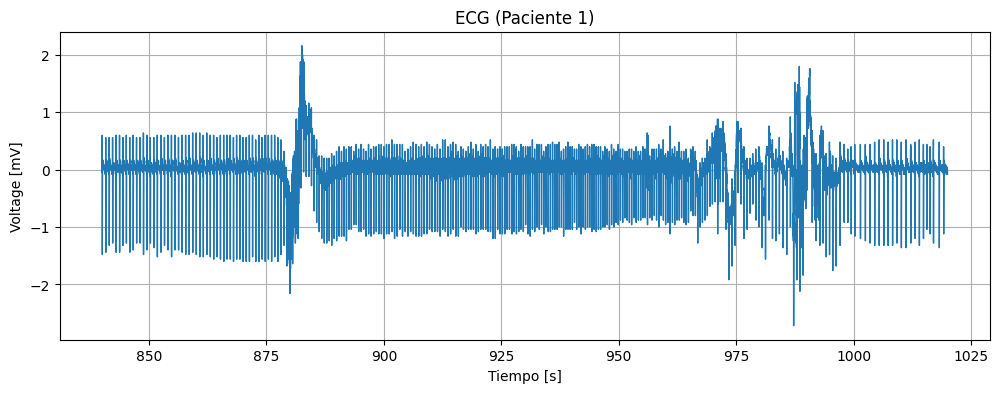

C:\Users\lolyy\AppData\Local\Temp\ipykernel_21572\1404609459.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


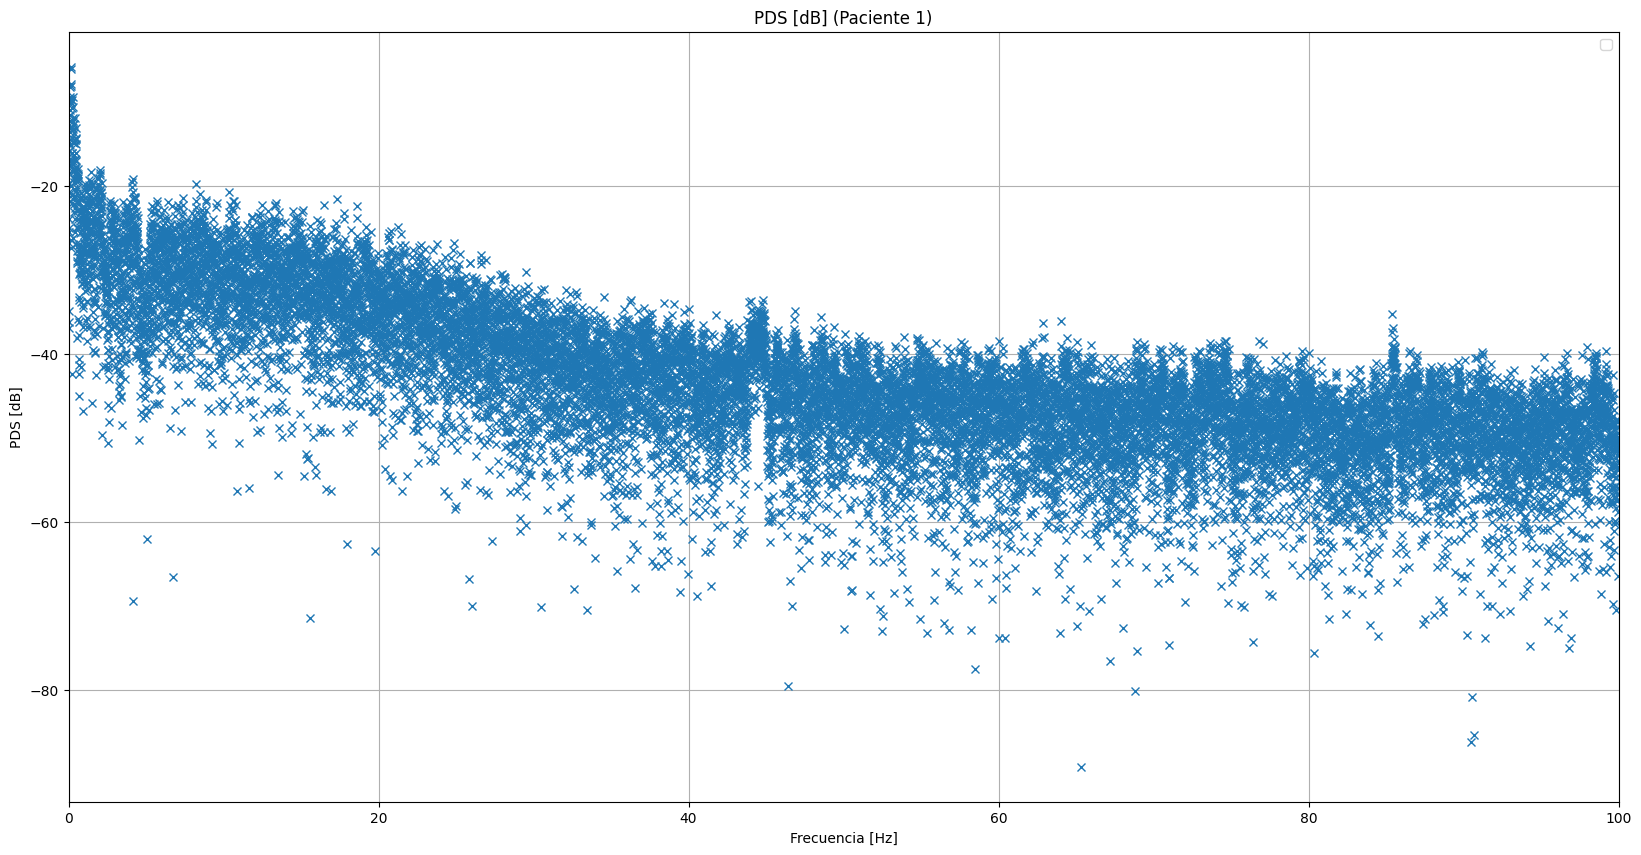

C:\Users\lolyy\AppData\Local\Temp\ipykernel_21572\996772516.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


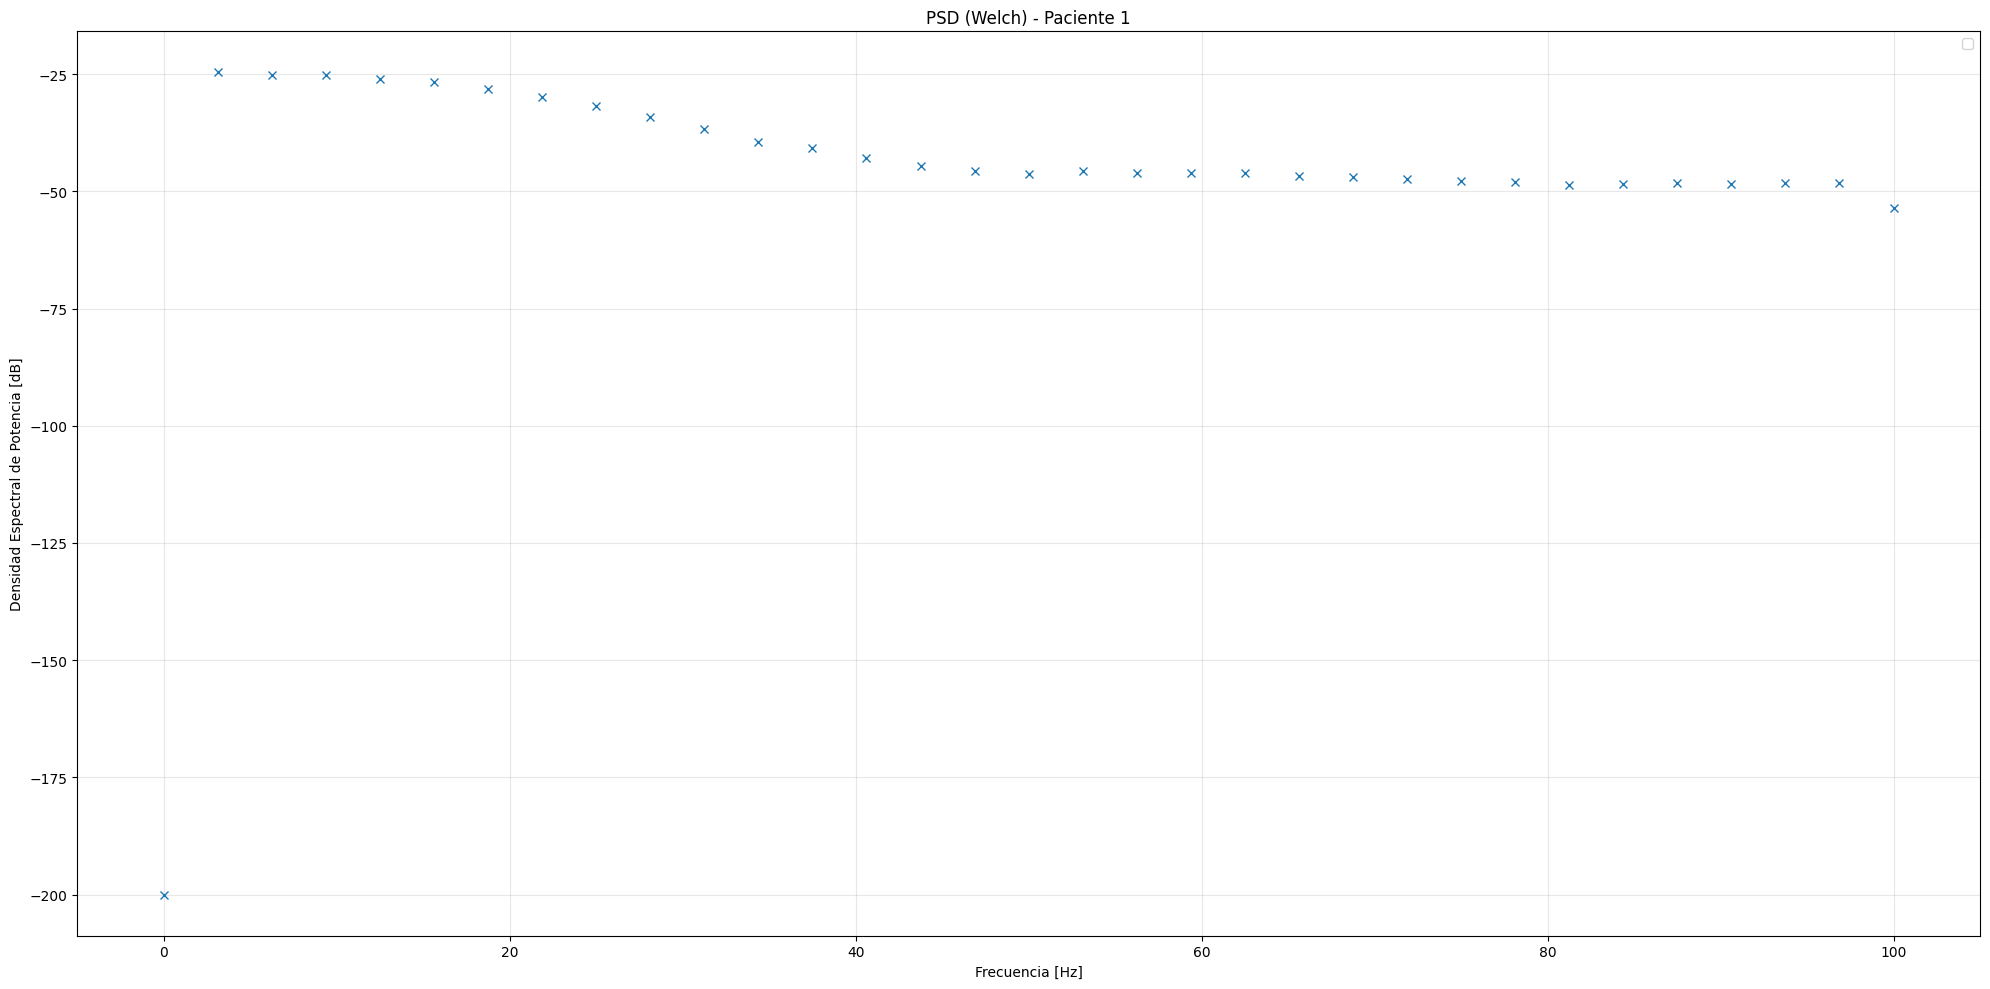

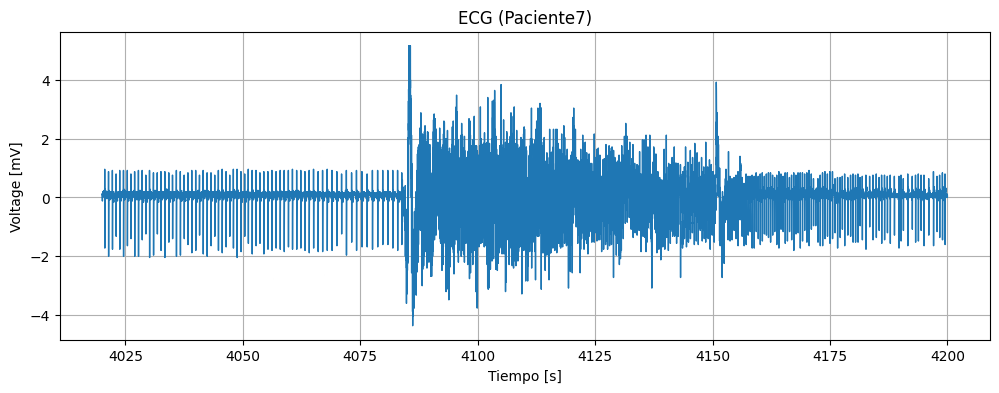

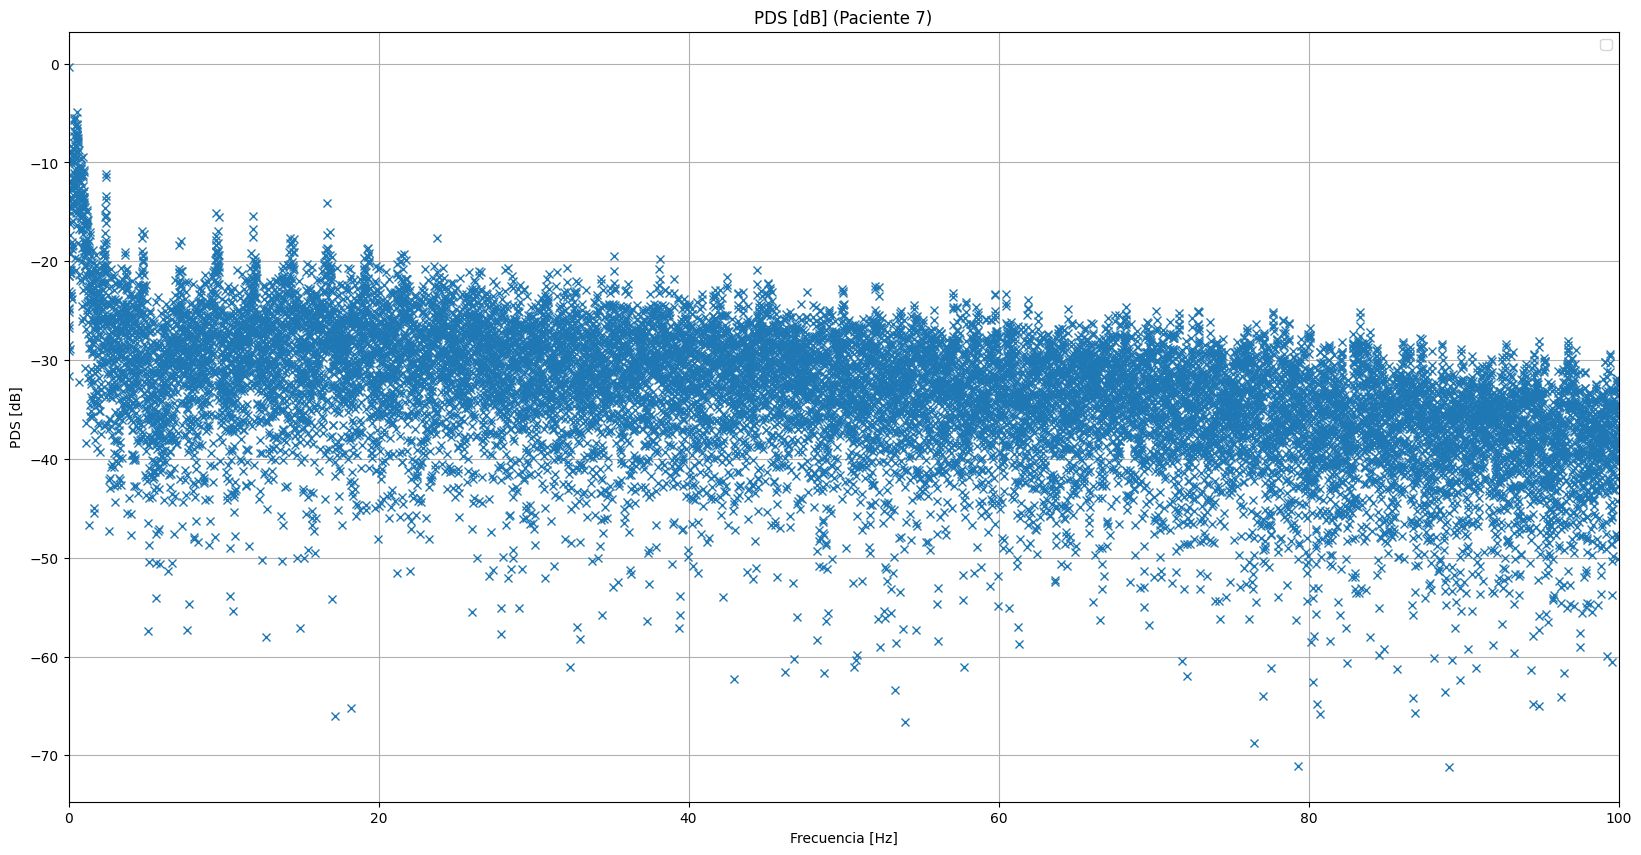

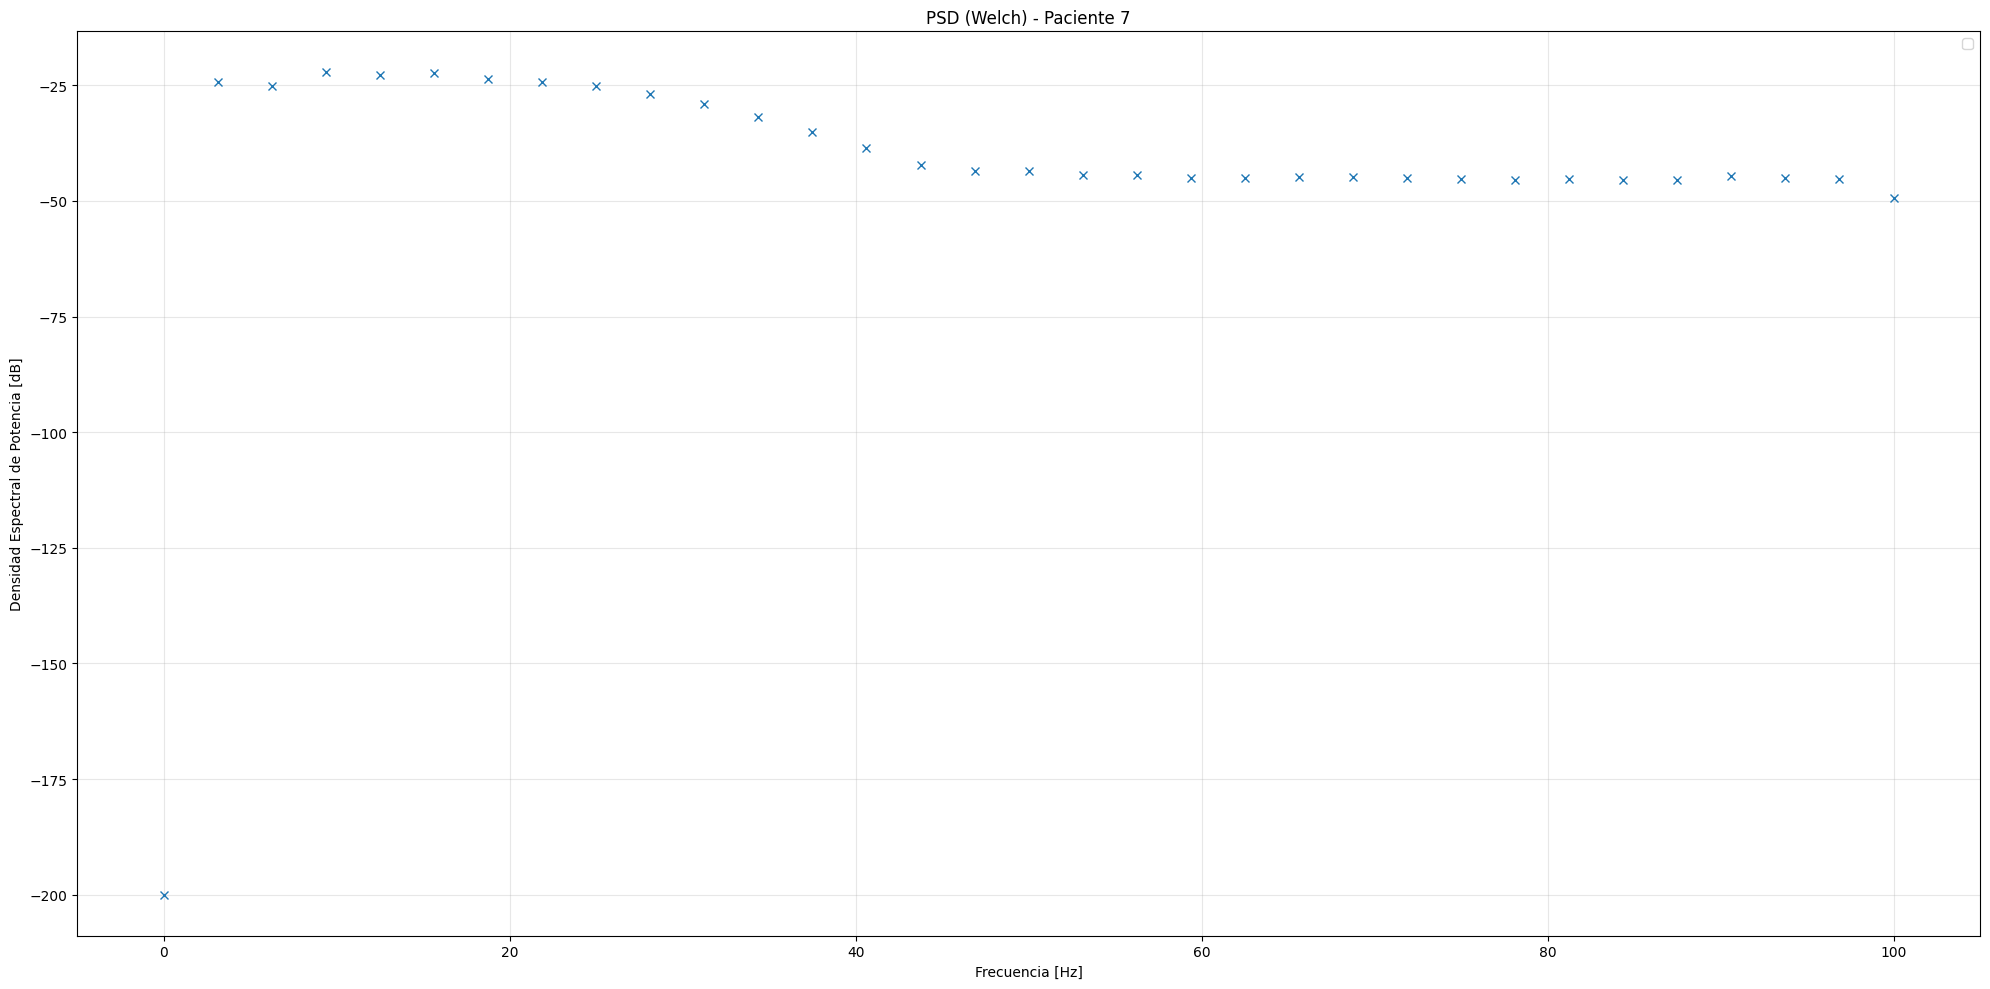

In [20]:
# %% main    

def main():
    files = [file for file in listdir('data')]
    paciente1 = files[0]
    ecg, t = leer_archivo(paciente1, 14, 17)
    graficar_archivo(ecg, t, "Paciente 1")
    transformada_rapida(ecg, "Paciente 1")
    welch(ecg,"Paciente 1")
    
    
    files = [file for file in listdir('data')]
    paciente7 = files[1]
    ecg, t = leer_archivo(paciente7, 67, 70)
    graficar_archivo(ecg, t, "Paciente7")
    Ff, PSD=transformada_rapida(ecg, "Paciente 7")
    f_ecg, pxx_ecg= welch(ecg,"Paciente 7")

if __name__=="__main__":
    main()

# **IV. Resultados**

# **V. Conclusiones**